# Random Forest Classifier

In [11]:
# IMPORT

# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score

# Plotting and tree visualization
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
import graphviz

## Data loading and preprocessing

Load the dataset and split it into training and test sets. The features 'X' are the number of hits, QCD/hits, shower width (both in x and y direction) for each station (20 columns). The target variable 'y' is the Starting station. The dataset is divided in two sets to train the model and test its performance.

In [ ]:
seed = 42 # reproducibility seed

def load_and_preprocess_data(path:str):
    
    '''
    Load data from the CSV file, separate features and target, split train and test sets.

    Parameters:
    - path: str 
        path to the data file

    Returns:
    - X_train, X_test: pandas.DataFrame
        training and testing features
    - y_train, y_test: pandas.Series
        training and test labels
    '''

    # Load
    df = pd.read_csv(path)

    # Preprocess
    X = df.drop(columns=['Starting station'])
    y = df['Starting station']

    # Split
    return train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

## Define and tune the model

Define the Random Forest Classifier. To address the class imbalance in the dataset, in the model we use class_weight='balanced' to assign weights inversely proportional to class frequency; in such way, the model reduces bias towards majority classes. 

Use RandomizedSearchCV to search parameters within a range per hyperparameters. The goal is to find the best hyperparameters for our model. RandomizedSearchCV trains different models and saves them as variables. <br>

Hyperparameters to tune:
1. n_estimators: number of decision trees in the forest. A high value improves the performance of the model but increases the computational cost of training and predicting.
2. max_depth: maximum depth of each decision tree in the forest. A high value can lead to overfitting; a low value can lead to underfitting. <br>

RandomizedSearchCV trains many models and saves them as variables. Using cross validation, it splits the data into equal-sized groups and using them to train or test the results. At the end, it averages the accuracy score of each group and finds the best model.

In [ ]:
n_iter = 5 # number of random search iterations
cv = 5 # number of cross-validation folds


def define_and_tune_model(X_train, y_train, param_dist=None):

    '''
    Define and tune a Random Forest model using RandomizedSearchCV with cross-validation.

    Parameters:
    - X_train: pandas.DataFrame
        training features
    - y_train: pandas.Series
        training labels
    - param_dist: dict
        hyperparameters distributions

    Returns:
    - best_estimator_: sklearn.ensemble.RandomForestClassifier
        trained model with the best hyperparameters

    '''
    # Define model
    model = RandomForestClassifier(class_weight='balanced', random_state=seed)

    if param_dist is None:
        # Define the hyperparameters to tune and their ranges in a dictionary
        param_dist = {'n_estimators': randint(50,500), 'max_depth': randint(1,20)}

    # Find the best hyperparameters
    rand_search = RandomizedSearchCV(estimator=model, param_distributions = param_dist, n_iter=n_iter, cv=cv, random_state=seed)

    # Fit the random search to the data
    rand_search.fit(X_train, y_train)

    print('Best hyperparameters:',  rand_search.best_params_)
    return rand_search.best_estimator_


## Evaluate the model 
Assess the performance of the trained model on the test set, checking:

1. Accuracy: proportion of correct predictions out of all predictions.
2. Classification Report. For each class, get:
    - Precision: proportion of correct predictions out of all predictions.
    - Recall: proportion of actual class samples correctly classified by the model.
    - F1-score: harmonic mean of precision and recall. 
    - Support: number of actual occurrences of the class in the dataset.
3. Confusion Matrix: compare the true (rows) and predicted (columns) classes.

In [14]:
def evaluate_model(model, X_test, y_test, display_cm=True):

    '''
    Evaluate the trained model and print accuracy, classification report, and confusion matrix.

    Parameters:
    - model: sklearn.ensemble.RandomForestClassifier
        trained Random Forest model
    - X_test: pandas.DataFrame
        test features
    - y_test: pandas.Series
        true labels
    - display_cm: bool, optional (default=True)
        whether to display the confusion matrix plot (set False to skip plotting)

    Returns:
    None
    '''

    y_pred = model.predict(X_test)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: ", accuracy)

    # Classification Report
    report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(report)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    if display_cm:
        display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
        display.plot()
        plt.title("Confusion Matrix")
        plt.show()


## Visualize the results

Use graphviz to visualize the trees. This package uses the format "DOT" as a graph description language. For example, here we visualize the first few nodes of the first tree. Each node contains three informations:
1. The variable name and the condition used to split the data.
2. The % of samples in each split.
3. The % of samples per class (Starting station) in each split. <br>

The color of each node represents the majority class predicted by that node. Saturated colors mean that the node is purer, whereas faded colors mean that the node is mixed.

In [15]:
def display_tree(model, feature_names=None, max_depth=2):

    '''
    Visualize a single decision tree from the Random Forest using graphviz

    Parameters:
    - model: sklearn.ensemble.RandomForestClassifier
        trained Random Forest model
    - feature_names: list
        list of feature names used for training
    - max depth: int, optional (default=2)
        maximum displayed depth of the tree

    Returns:
    None
    '''
    tree = model.estimators_[0]
    dot_data = export_graphviz(tree, feature_names=feature_names, filled=True, max_depth=max_depth, impurity=False, proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

## Feature Importance

Plot the Feature Importance to quantify the usefulness of each feature in the model. A higher score means that the feature contributes more to the accuracy of the classification. Note that the importance score on the y axis is relative, not percentage.

In [ ]:
def plot_feature_importance(model, feature_names):
    
    '''
    Plot the feature importances from the fitted Random Forest model.

    Parameters:
    - model: sklearn.ensemble.RandomForestClassifier
        trained Random Forest model
    - feature_names: list
        list of feature names used for training

    Returns:
    None
    '''

    feature_importances = model.feature_importances_
    indices = np.argsort(feature_importances)[::-1]

    plt.figure()
    plt.title("Feature Importance", fontsize=16)
    plt.bar(range(len(feature_importances)), feature_importances[indices], align="center")
    plt.xticks(range(len(feature_importances)), feature_names[indices], rotation=90)
    plt.ylabel("Importance Score")
    plt.show()

# Model training and evaluation

Finally, we train and evaluate the Random Forest and visualize the results.

1. load_and_preprocess_data(): loads the dataset and prepares the features X and labels y.
2. define_and_tune_model(): defines a Random Forest Classifier and tunes the hyperparameters (n_estimators and max_depth).
3. Evaluate cross-validation performance by computing the mean accuracy and standard deviation across folds.
4. evaluate_model(): evaluates the trained model on the test sets, printing accuracy and classification report and displaying the correlation matrix (optional).
5. display_tree(): visualizes the first tree from the Random Forest using graphviz.
6. plot_feature_importance(): plots the feature importance.

Best hyperparameters: {'max_depth': 15, 'n_estimators': 156}
Accuracy:  0.8932584269662921
Classification Report:
              precision    recall  f1-score   support

          -1       0.94      0.96      0.95       133
           1       0.90      0.82      0.86        11
           2       0.56      0.71      0.62         7
           3       0.67      0.89      0.76         9
           4       0.75      0.43      0.55         7
           5       0.86      0.55      0.67        11

    accuracy                           0.89       178
   macro avg       0.78      0.73      0.73       178
weighted avg       0.90      0.89      0.89       178



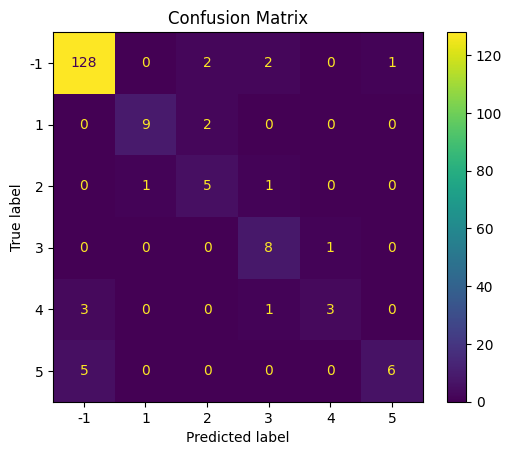

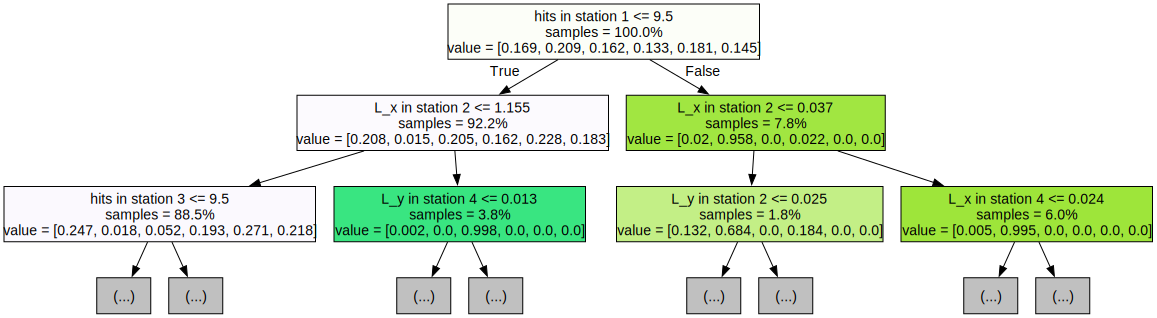

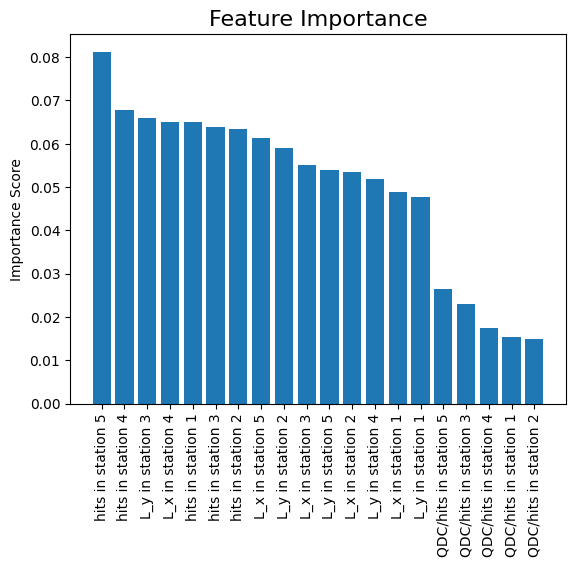

In [ ]:
# Load and preprocess data
X_train, X_test, y_train, y_test = load_and_preprocess_data("data.csv")

# Define and tune model
best_rf = define_and_tune_model(X_train, y_train)

# Cross-validation
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=cv)
print("Cross-validation scores: ", cv_scores)
print("Mean CV accuracy: ", cv_scores.mean())
print("CV scores standard deviation: ", cv_scores.std())

# Evaluate the model
evaluate_model(best_rf, X_test, y_test)

# Visualize the first decision tree
display_tree(best_rf, feature_names=X_train.columns, max_depth=2)

# Plot the Feature Importance
plot_feature_importance(best_rf, feature_names=X_train.columns)

The model reports a good overall performance, with an accuracy of 89%. However, performance metrics for minority classes, especially 2 and 3, are clearly lower than the ones for the predominant class -1. This is a direct consequence of the class imbalance of the dataset. An improvement of the MonteCarlo simulation, combined with a wider dataset, will be necessary to obtain a better classification accuracy for all classes.